# 3. 港湾におけるターミナル運用の変化を検出できるようにする

このセクションは、ALOS-2による港湾のターミナル運用の変化を検出することに興味のある学習者のために設計されています。

はじめに必要なパッケージをインストールします。

In [ ]:
!conda install -c conda-forge rasterio geopandas -y

## 主な学習目標：
- スペックルノイズを低減する前処理
- ALOS-2衛星画像によるトヨタ自動車名古屋港施設の可視化
- COVID-19危機における港湾作業の変化検出

## 3.1 ALOS-2/PALSAR-2データの前処理

本節では、ALOS-2 合成開口レーダ(SAR)画像を解析するための前処理について述べる。
- ALOS-2 画像のダウンロード
- センサ関連のバイアスを調整するためのキャリブレーション
- スペックルノイズを低減するための Lee フィルタの適用

### 3.1.1. ALOS-2/PALSAR-2データのダウンロード・展開

In [ ]:
#!curl --output "Shimpomachi_ngo.zip" "https://owncloud.glodal-inc.net/owncloud/index.php/s/7LpA8rRJjIUFabL/download"

import shutil, os
shutil.unpack_archive("Shimpomachi_ngo.zip", ".")
os.chdir('Shimpomachi_ngo')
os.listdir()

### 3.1.2. ALOS-2/PALSAR-2データの読み込み

このPythonコードは、ALOS-2のSAR画像を読み込むためのもので、指定したフォルダにある全ての.tifファイルのパスを読み込みます。

この演習用データのファイルは観測日の数字を含む HH-YYMMDD.tif で命名されます。

In [ ]:
import os

# フォルダ内のすべてのGeoTIFFファイルを検索する
alos_files = [f for f in os.listdir() if f.endswith('.tif')]

if not alos_files:
    raise FileNotFoundError("No GeoTIFF files found in the specified directory.")
    
# 見つかったファイルのリストを表示する
print("ALOS-2 files to visualize:")
for file in alos_files:
    print(file)


### 3.1.3. ALOS-2/PALSAR-2データの表示

このセルは、フォルダ内で見つかった各画像を表示します。

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import os

# カラーマップを選ぶ
color_map = 'gray'  # Options: 'gray', 'viridis', 'plasma', 'inferno', 'jet', 'cividis', etc.

# グリッドの列数を定義する
n_cols = 2
n_rows = (len(alos_files) + n_cols - 1) // n_cols  # Calculate required rows based on the number of files

# サブプロットでフィギュアを作る
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6))
axes = axes.flatten()  # Flatten to make it easy to iterate over

alos_image = list()
# 各ファイルをループし、選択したカラーマップで画像を可視化する。
for idx, alos_path in enumerate(alos_files):
    with rasterio.open(alos_path) as src:
        alos_image.append(src.read(1))  # 最初のバンドを読む（シングルバンドのデータを想定）

    # それぞれのサブプロットに画像をプロットする
    ax = axes[idx]
    img = ax.imshow(alos_image[idx], cmap=color_map)
    ax.set_title(f"{os.path.basename(alos_path)} ({color_map})")
    fig.colorbar(img, ax=ax)
    ax.axis('off')

# 使われていないサブプロットを隠す
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### 3.1.4. スペックルノイズの低減

Leeフィルタは、移動窓の局所統計量(平均と分散)を計算し、エッジを保存しながらスペックルノイズを低減するために使用します。このセルはlee_filter関数を定義し、ディレクトリ内の各ALOS-2画像に適用します。フィルタリングされた画像は辞書 filtered_images に格納される。

注意: lee_filter() 関数の size=3 パラメータは、各ピクセルの局所統計量(平均、分散)を計算するために使用される正方形の窓またはカーネルのサイズを意味する。この場合，3x3の窓が各ピクセルの周りに適用されます．

In [7]:
import numpy as np
from scipy.ndimage import uniform_filter

# リー・フィルター関数を定義する
def lee_filter(image, size):
    """
    Applies the Lee filter to an input image to reduce speckle noise.
    
    Parameters:
        image (numpy.ndarray): The input image to be filtered.
        size (int or tuple): The size of the local neighborhood (e.g., window size).
        
    Returns:
        numpy.ndarray: The filtered image.
    """
    # Ensure the input image is a floating-point array for precision
    image = image.astype(np.float32)
    
    # Calculate local mean and squared mean using uniform filter
    local_mean = uniform_filter(image, size=size)
    local_mean_sqr = uniform_filter(image**2, size=size)
    
    # Calculate local variance
    local_variance = local_mean_sqr - local_mean**2
    
    # Estimate noise variance (overall variance of the image)
    overall_variance = np.mean(local_variance)
    
    # Compute the filter weight
    weight = local_variance / (local_variance + overall_variance)
    weight = np.clip(weight, 0, 1)  # Ensure weight is in a valid range
    
    # Apply the Lee filter formula
    filtered_image = local_mean + weight * (image - local_mean)
    
    return filtered_image

# Leeフィルターを適用する
filtered_images = list()
for img in alos_image:
    filtered_images.append(lee_filter(img, size=3))  # Adjust size as needed


### 3.1.5. DNを後方散乱係数に変換

較正係数を適用し、デジタル数値(DN)を後方散乱値(dB)に変換します。[詳しくはリンク先](https://www.eorc.jaxa.jp/ALOS/en/alos-2/a2_calval_e.htm)

$$ \sigma^0_{Q16} = 10 log_{10}<DN^2> + CF$$

ただし、<>はノイズ低減のための平均化を表し、CFには-83.0 dBを用いる。以下にコーディング例を示します。

In [9]:
import numpy as np
import rasterio

# 画像をキャリブレーションする関数を定義する
def calibrate_image(image):
    # 負の値をクリップして、正でない値の対数を取らないようにする。
    clipped_image = np.clip(image, a_min=1e-10, a_max=None)  # Prevent log(0)
    # 校正式を適用する
    calibrated_image = (10 * np.log10(clipped_image**2)) - 83
    return calibrated_image

# オリジナル画像にキャリブレーションを適用し、リストに保存する。
preprocessed_images = []
for img in filtered_images:
    # オリジナル画像のキャリブレーション
    preprocessed_images.append(calibrate_image(img))


### 3.1.6. 前処理結果の表示

In [ ]:
import matplotlib.pyplot as plt
import os
import rasterio

# オリジナル画像、キャリブレーション画像、フィルタリング画像を並べて表示
for i in range(0, len(alos_files)):
    # プロット
    plt.figure(figsize=(15, 5))

    # オリジナル・イメージ
    plt.subplot(1, 3, 1)
    plt.imshow(alos_image[i], cmap='gray')
    plt.title(f"Original Image - {os.path.basename(alos_files[i])}")
    plt.colorbar()

    # フィルター画像
    plt.subplot(1, 3, 2)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(f"Filtered Image - {os.path.basename(alos_files[i])}")
    plt.colorbar()

    # キャリブレーション画像
    plt.subplot(1, 3, 3)
    plt.imshow(preprocessed_images[i], cmap='gray')
    plt.title(f"Calibrated Image - {os.path.basename(alos_files[i])}")
    plt.colorbar()


    plt.tight_layout()
    plt.show()


### 3.1.7. (オプショナル) GeoTIFFとして保存する

In [ ]:
import rasterio

# フィルタリングした画像をGeoTIFFとして書き出す
for i in range(0, 7):
    output_filename = os.path.basename(alos_files[i]).replace('.tif', '_filtered.tif')
    
    with rasterio.open(alos_files[i]) as src:
        # 元画像からメタデータを取得
        meta = src.meta.copy()
        meta.update({
            'height': preprocessed_images[i].shape[0],
            'width': preprocessed_images[i].shape[1],
            'dtype': 'float32',  # Change to 'float32' for filtered images
        })
    
    # 前処理された画像を新しいGeoTIFFファイルに書き込む
    with rasterio.open(output_filename, 'w', **meta) as dst:
        dst.write(preprocessed_images[i].astype('float32'), 1)  # Write the first band

    print(f"Filtered image saved as: {output_filename}")

## 3.2. ALOS-2/PALSAR-2によるトヨタ自動車名古屋港施設のモニタリング

このセクションでは：
- COVID-19危機における生産抑制周辺のいくつかの観測を可視化し、他の可視光画像と比較する。
- カラー合成で変化を視覚化し、コロナ禍による生産抑制との関連性を説明する。
- TOYOTAにおける生産抑制を示すサンプル地点/地域の時系列プロファイルを示す。

### 3.2.1. COVID-19危機における生産抑制周辺のいくつかの観測を可視化し、他の可視光画像と比較する

#### 前処理済み画像を表示する

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt

# カラーマップを選ぶ
color_map = 'gray'  # 必要に応じてカラーマップを変更できる

# サブプロットに必要な行数を決める
num_images = len(preprocessed_images)
num_columns = 2
num_rows = (num_images + num_columns - 1) // num_columns  # 行を得るための天井分割

# Create a figure with subplots
plt.figure(figsize=(15, num_rows * 5))  # 行数に応じて図のサイズを調整する

# 前処理された各ファイルをループし、サブプロットに追加する。
for i in range(0, 7):
    # 各画像にサブプロットを作成する
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(preprocessed_images[i], cmap=color_map)
    plt.colorbar()
    plt.title(f"{os.path.basename(alos_files[i]).replace('.tif','')}")
    plt.axis("off")

# 重ならないようにレイアウトを調整
plt.tight_layout()
plt.show()


#### Sentinel-2の画像と観測結果を比較する

一致する日付のこれら2つのソースからの観測を比較することで、サンプリングされた場所の特徴や土地被覆が時間とともにどのように変化したかを分析することができます。これにより、1つのデータタイプだけでは見えない微妙な変化を浮き彫りにすることができます。

- ALOS-2/PALSAR-2（SAR）： これらの画像は、天候や照明条件に関係なく、地表の変化や構造に関する洞察を提供する。3つの日付（191127年、210303年、220302年）から、危機前、危機中、危機後のインフラや表面の粗さの変化を追跡することができます。
- Sentinel-2（光学）： これらの画像は、可視および近赤外バンドの反射率をキャプチャします。Sentinel-2の画像（2019年11月、2021年3月、2022年3月）を比較することで、興味深い地域周辺の土地被覆の変化や活動に関する洞察が得られます。

以下に別の手順で表示した画像との比較例を示します。

##### 2019年11月

|The observations (ALOS-2 image : 191127)|
|-------------------------------|
|![ALOS-2_1](9fil191127.png)|

|Location| ALOS-2 image (filtered image) | Sentinel-2 image (Nov19) |
|---|-------------------------------|------------------|
| A | ![ALOS-2_A](9fil_1.png) | ![Sentinel-2_A](9fil_2.png) |
| B | ![ALOS-2_B](9fil_3.png) | ![Sentinel-2_B](9fil_4.png) |
| C | ![ALOS-2_C](9fil_5.png) | ![Sentinel-2_C](9fil_6.png) |

-------

##### 2021年3月

|The observations (ALOS-2 image : 210303)|
|-------------------------------|
|![ALOS-2_1](10fil210303.png)|

|Location| ALOS-2 image (filtered image) | Sentinel-2 image (Mar21) |
|-|-------------------------------|------------------|
| A | ![ALOS-2_A](10fil_1.png) | ![Sentinel-2_A](10fil_2.png) |
| B | ![ALOS-2_B](10fil_3.png) | ![Sentinel-2_B](10fil_4.png) |
| C | ![ALOS-2_C](10fil_5.png) | ![Sentinel-2_C](10fil_6.png) |

-------

##### 2022年3月

|The observations (ALOS-2 image : 220302)|
|-------------------------------|
|![ALOS-2_1](11fil220302.png)|

|Location| ALOS-2 image (filtered image) | Sentinel-2 image (Mar22) |
|-|-------------------------------|------------------|
| A | ![ALOS-2_A](11fil_1.png) | ![Sentinel-2_A](11fil_2.png) |
| B | ![ALOS-2_B](11fil_3.png) | ![Sentinel-2_B](11fil_4.png) |
| C | ![ALOS-2_C](11fil_5.png) | ![Sentinel-2_C](11fil_6.png) |

-------

#### 参考：2021年12月・地点Ｃの南部

後方散乱係数と自動車の出荷状況には関連がありそうです。

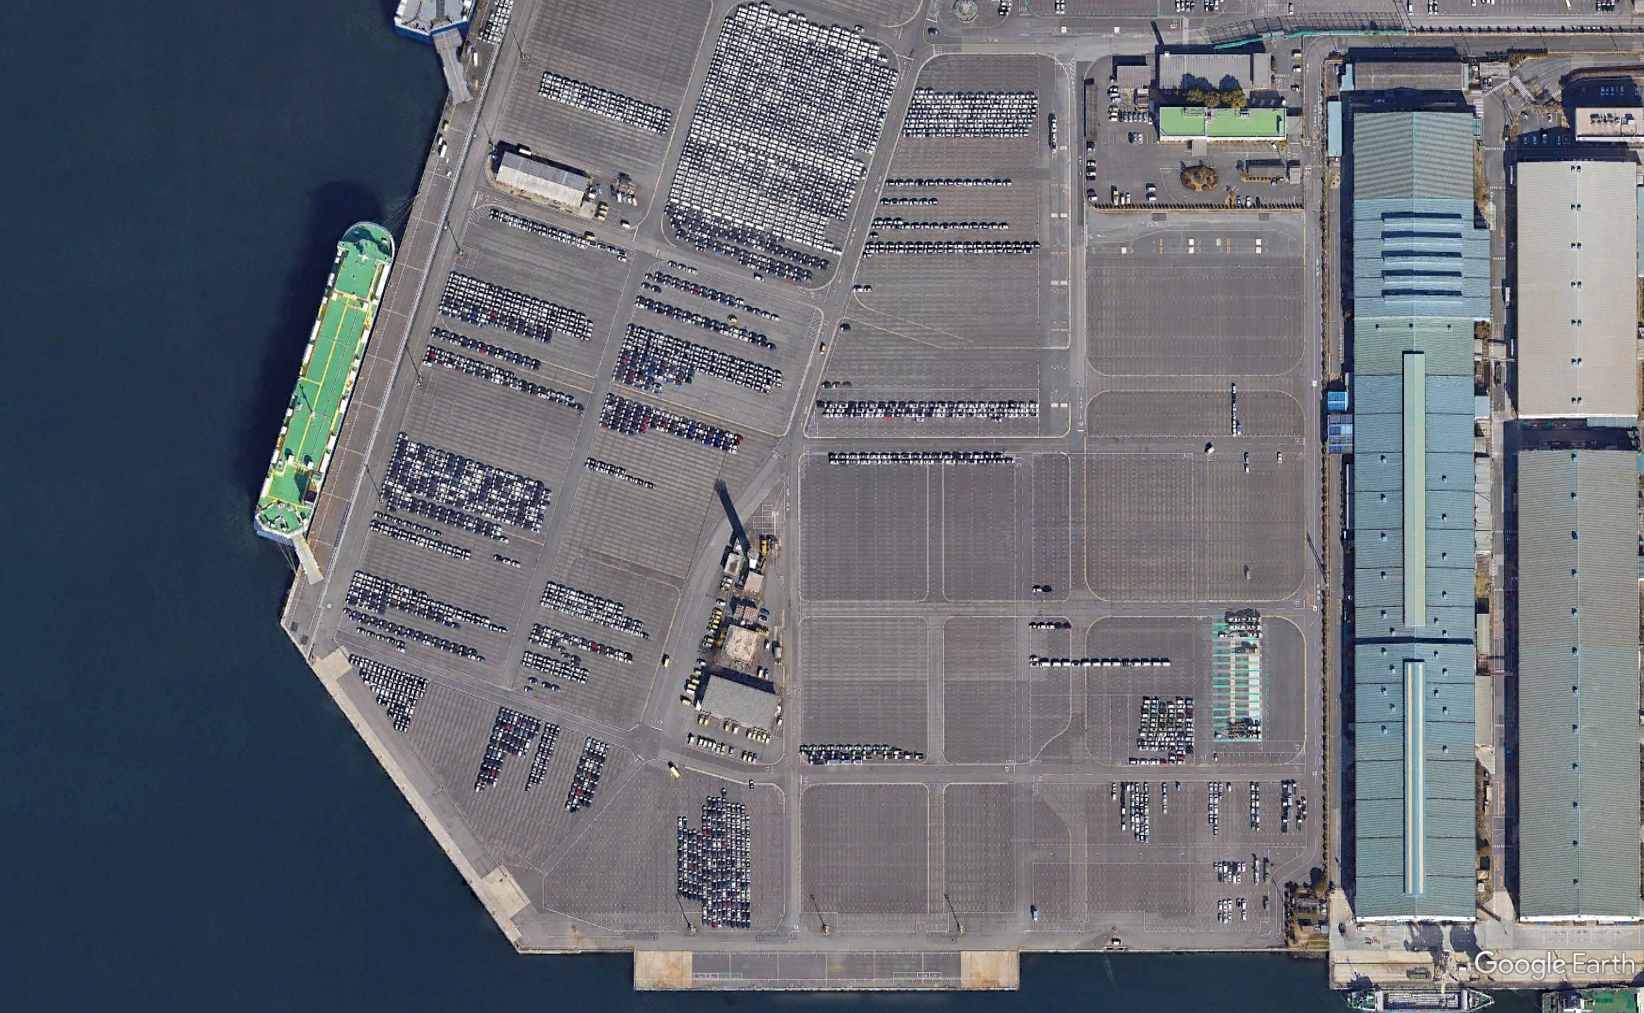

### 3.2.2 カラー合成で変化を可視化し、生産抑制との関連性を説明する。

時間 RGB 合成画像の作成は、複数の SAR 画像の違いを可視化するのに便利です。ここでは ALOS-2 の画像を扱っているため、RGB チャンネルに異なるバンドやタイムスタンプ画像を割り当てるのが一般的な手法です。

赤、緑、青の各チャンネルにフィルタリングされた2つの画像を合成することで、RGB合成画像を作成することができます。2つの画像があるので、1つの画像を赤チャンネルに、もう1つの画像を緑チャンネルに割り当て、青チャンネルにはそれらの平均か空の配列を使うという方法もあります。

**擬似カラー合成の手順**

1. ２以上の観測データを選択する。
2. これらを赤、緑、青チャンネルに割り当てる。
3. RGB画像として表示されるように、ピクセル値を[0, 1]の範囲になるように正規化する。
4. matpotlib を使ってカラー合成を表示します。

注：red_channel、green_channel、blue_channelは、強調したいデータや分析の側面に応じて、好きなフィルター画像パスに置き換えることができます。

In [ ]:
import re
import rasterio
import numpy as np
import matplotlib.pyplot as plt
    
# ファイル名から日付を抽出する
def extract_date(filename):
    # 日付をキャプチャする正規表現パターン（例：'191127'）
    match = re.search(r'\d{6}', filename)
    return match.group(0) if match else "Unknown date"

# 各ファイルのインデックスと日付を印刷する
for index in range(0, len(alos_files)):
    date = extract_date(alos_files[index])
    print(f"Index {index}: {alos_files[index]} (Date: {date})")

# 使用する2つの画像のインデックスを指定する。
red_index = 0  # 赤チャンネルの画像インデックス
green_index = 1  # 緑チャンネルの画像インデックス
blue_index = 1  # グリーン・チャンネルの画像をブルー・チャンネルに再利用する。

# 指定したチャンネルの画像を読み込む
red_channel   = preprocessed_images[red_index]
green_channel = preprocessed_images[green_index]
blue_channel  = preprocessed_images[blue_index]

# RGB可視化のためにチャンネルを範囲[0, 1]に正規化する。
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

# 正規化を適用する
red_channel_norm   = normalize(red_channel)
green_channel_norm = normalize(green_channel)
blue_channel_norm  = normalize(blue_channel)

# 正規化されたチャンネルをスタックしてRGB合成画像を作成する。
rgb_composite = np.stack((red_channel_norm, green_channel_norm, blue_channel_norm), axis=-1)

# チャンネルの日付を取得する
red_date = extract_date(alos_files[red_index])
green_date = extract_date(alos_files[green_index])
blue_date = extract_date(alos_files[blue_index])

# RGBコンポジットの可視化
plt.figure(figsize=(8, 8))
plt.imshow(rgb_composite)
plt.title(f"RGB Composite Image (Red: {red_date}, Green: {green_date}, Blue: {blue_date})")
plt.axis('off')
plt.show()



RGB合成画像は、2019年11月27日と2020年3月4日に撮影されたALOS-2 PALSAR-2の時間的変化を強調して表示します。コンポジットでは、2つの日付の間で変化していない領域がグレースケールで表示され、RGBの組み合わせの結果となっています。赤い領域は、11月27日にのみ物体や構造物が存在していた領域を示しており、3月4日までに除去されたか変化したことを示唆している。逆に、青い領域は、3月4日の画像にのみ物体が出現した領域を示し、この間に発生した新たな発展や変化を示している。このような可視化により、インフラ、土地利用、その他の特徴の経時的変化を効果的に強調し、正確な変化を検出することができる。

### 3.2.3 TOYOTA の生産抑制を示す時系列プロファイルを表示する。

このコードは、時系列ラスター画像をスタックして、ALOS-2 後方散乱データの時間変化を解析する。スタックされたラスターデータ上でAOI(Area of Interest; 関心領域)のジオメトリをマスクすることにより、各時間レイヤーの後方散乱の中央値を計算する。時間層は可視化のために様々な日付のALOS-2画像に対応している。その結果はプロットされ、各AOIの経時的な後方散乱の傾向を示し、反射表面特性の変化を追跡することができ、AOI内の表面状態の変化を示す可能性があります。

下図の赤色境界線内を本節で扱うAOIとします。

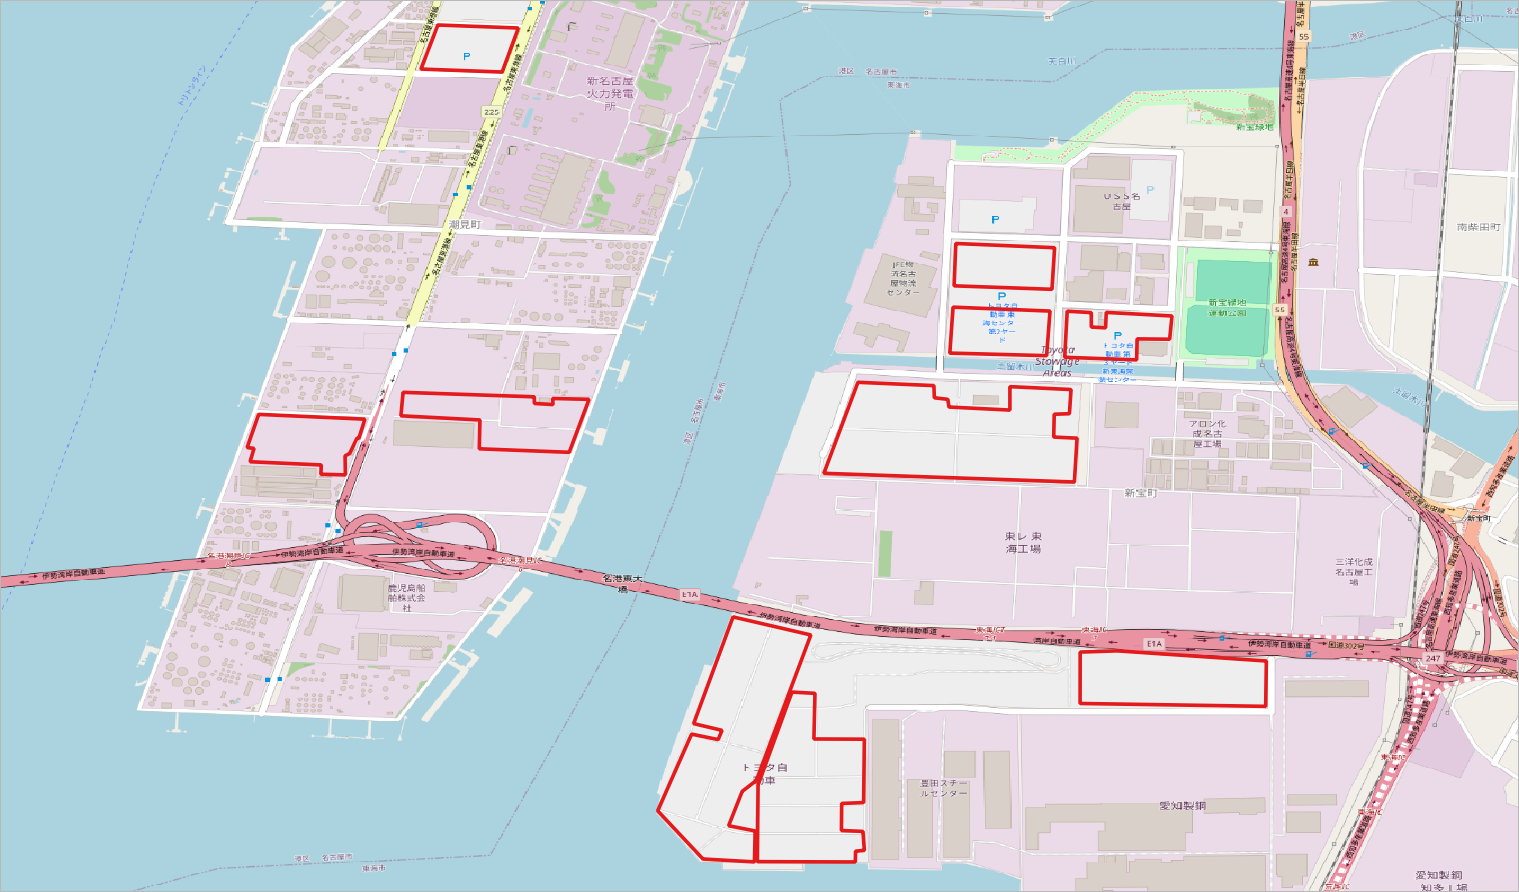


In [ ]:
import rasterio
import numpy as np
import os

# リストをnumpyの3次元配列に変換（高さ、幅、時間）
time_series_stack = np.stack(preprocessed_images, axis=-1)

# スタックの基本情報を表示する
print("Time-Series Stack Shape (Height, Width, Time):", time_series_stack.shape)
print("Number of Layers (Time Dimension):", time_series_stack.shape[-1])


ここでAOI毎に後方散乱係数の中央値を計算します。

- ALOS-2 スタック画像と AOI (Area of Interest) ファイルのファイルパスを指定する(自分でAOIファイルを作成するか、以下セルでダウンロードしてください)。
- 積み重ねられたイメージの各バンドに対応する年を定義し、模倣された時点を作成して下さい

In [ ]:
!curl --output aoi_toyota.gpkg "https://owncloud.glodal-inc.net/owncloud/index.php/s/xPdaXgH00OwQKFQ/download"

In [ ]:
import rasterio
import rasterio.features  # 機能を明示的にインポートする
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

median_values_all = {}  # 各 AOI の中央値を格納する辞書

# geopandas を使用して AOI ジオメトリをロードする。
aoi_gdf = gpd.read_file('aoi_toyota.gpkg')

# すべてのジオメトリを組み合わせて、AOI 全体の空のマスクを初期化する。
combined_mask = np.zeros(time_series_stack.shape[:2], dtype=bool)
for geom in aoi_gdf.geometry:
    # ジオメトリが有効な場合は、スタック画像の解像度に合わせてラスタライズする。
    if geom.is_valid:
        mask = rasterio.features.geometry_mask([geom], transform=src.transform, invert=True, out_shape=combined_mask.shape)
        combined_mask = np.logical_or(combined_mask, mask)

# 各時点（band）の後方散乱係数の中央値を計算する
median_values = []
for band in range(time_series_stack.shape[-1]):
    band_data = time_series_stack[:,:,band]  # 現在のバンドのデータを抽出する
    # マスク領域の中央値を計算する
    median_value = np.median(band_data[combined_mask])
    median_values.append(median_value)

# 中央値を時系列プロット
dates = [191127, 200304, 200610, 210303, 210609, 211124, 220302] 
time_points = np.arange(0, len(dates) * 7, 7)  # 時間間隔は7日の倍数

plt.figure(figsize=(10, 6))
plt.plot(time_points, median_values, marker='o', label='Median AOI Value')

plt.title(f'Median Value of the AOI Over Time')
plt.xlabel('Date')
plt.ylabel('Median Backscatter Coefficient')
plt.xticks(time_points, labels=dates, rotation=45)  # Display original years as labels
plt.grid()
plt.legend(title='AOI')
plt.tight_layout()
plt.show()

**全体的な傾向：**
このグラフは、トヨタの生産指標の全般的な低下傾向を示しており、すべての日付でマイナス値が示されているが、期間を通じて多少の変動がある。この減少傾向はCOVID-19パンデミックのサプライチェーンへの影響と関連していると思われる。生産回復に向けたトヨタの努力は目に見える形で現れているが、データ・ポイントは、特に国内事業における継続的な課題を示唆している。

- 191127～200304：初期のパンデミック関連の混乱とCOVID-19の初期波によるものと思われる。
- 200304～200610： 200304年から200610年：さらに減少しており、パンデミック問題の深刻化と、おそらく初期の世界的なチップ不足に一致して、生産への影響が深まっていることを示している。
- 200610～210303：わずかな回復と増加。これは、パンデミックの影響が続いているにもかかわらず、トヨタが通常生産の再開を目指したことによるわずかな改善を示唆している。
- 210303～210609まで：COVID-19の混乱が断続的に続いたが、この期間の生産調整と回復の試みを示唆するプラスの変化。
- 210609～211124：COVID-19の再流行とサプライチェーンの制約がトヨタの生産に影響を及ぼしたためとみられる。
- 211124～220302まで： 最後のポイントは、供給問題が安定し始め、トヨタの生産戦略が継続的な制約に適応する可能性があることから、段階的な回復を示唆している。


## 3.3. COVID-19 危機における港湾事業の変化検出

- 危機前，危機中，危機後（利用可能な場合）のオブザベーションをサンプリングする．
- 2つのオブザベーション間の差を計算する．
     - 危機前と危機中：TOYOTAの生産後退
     - 危機前と危機後：TOYOTA の生産の回復
- Google Earthの過去の画像で、サンプリングした場所の変化を検証する。

### 3.3.1 危機発生前、危機発生中、危機発生後のサンプル観測値

これらの画像は、COVID-19パンデミックにおけるトヨタの活動の主要な段階を表すものとして、以下の記事で紹介されている：

- 危機前（191127）： この日付は2019年11月27日で、パンデミックの影響が日本に及ぶ前の状況を捉えたベースライン画像となっている。
- インクライシス（200610）： 2020年6月10日の画像は、COVID-19に関連した減産、（チップ不足などの）サプライチェーンの混乱、健康への適応などの影響を受け、特に日本の製造業や自動車産業で混乱が最高潮に達した時期と一致している。このタイミングは、トヨタが危機の間に直面した経営上の課題についての洞察を提供する。
- 危機後（211124）： 2021年11月24日までに、日本は回復に向かって移行していた。トヨタをはじめとするメーカー各社は回復の兆しを見せたが、COVID-19の断続的な発生や残存部品の不足が依然として課題となっていた。この画像は、トヨタのフル稼働に向けた慎重ながらも緩やかな動きを反映してい

In [ ]:
# 画像を読み取り、正規化する
pre_crisis = preprocessed_images[0]
in_crisis  = preprocessed_images[2]
post_crisis = preprocessed_images[5]


# 視覚化のために図を設定する
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 各画像をカラーバーでプロットする
im1 = axes[0].imshow(pre_crisis, cmap='gray')
axes[0].set_title("Pre_crisis: 191127")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

im2 = axes[1].imshow(in_crisis, cmap='gray')
axes[1].set_title("In_crisis: 200610")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

im3 = axes[2].imshow(post_crisis, cmap='gray')
axes[2].set_title("Post_crisis: 211124")
axes[2].axis("off")
fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

# レイアウトを調整し、プロットを表示する
plt.tight_layout()
plt.show()



### 3.3.2 ２時期の観測値の差の計算

- この演習では、COVID-19 の危機前と危機中の差を計算するために、191127 と 200610 の画像を使用する。
- そのほか、COVID-19の危機中（200610）と危機後（211124）の変化に関する分析も余裕があればやってみましょう。

**危機前と危機中の差分画像を計算**: 危機前画像の各ピクセルから危機中画像の対応するピクセル値を差し引く。

In [ ]:
difference_caseA = in_crisis - pre_crisis


# 視覚化のために図を設定する
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 危機前の画像をカラーバーでプロットする。
im1 = axes[0].imshow(pre_crisis, cmap='gray')
axes[0].set_title("Pre_crisis Image : 191127")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)

# in_crisis 画像をカラーバーでプロットする。
im2 = axes[1].imshow(in_crisis, cmap='gray')
axes[1].set_title("In_crisis Image : 200610")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)

# 差分画像をカラーバーでプロットする
im3 = axes[2].imshow(difference_caseA, cmap='RdYlGn')
axes[2].set_title("Difference (In - Pre)")
axes[2].axis("off")
fig.colorbar(im3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)

# レイアウトを調整し、プロットを表示する
plt.tight_layout()
plt.show()


**差分画像（分類前）のヒストグラムを平均値と中央値でプロットする。**

In [ ]:

# 以下の変数が定義されていると仮定する：
# 危機前のデータ、危機中のデータ

# ケース1の平均値、中央値、標準偏差を計算する。
mean_diff_caseA = np.mean(difference_caseA)
median_diff_caseA = np.median(difference_caseA)
std_diff_caseA = np.std(difference_caseA)

# ケースAのプロット・ヒストグラム
plt.figure(figsize=(6, 6))
plt.hist(difference_caseA.ravel(), bins=50, color='blue', alpha=0.7)
plt.axvline(mean_diff_caseA, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_diff_caseA:.2f}')
plt.axvline(median_diff_caseA, color='orange', linestyle='dotted', linewidth=1, label=f'Median: {median_diff_caseA:.2f}')
plt.title("Histogram of Difference Image (In Crisis - Pre Crisis)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**分類しきい値の定義と分類の適用**

差分画像の画素値の分布は正規分布なので両側2.5%を有意な変化とみなして「変化あり」「変化無し」に分類します。

以下のコードは、画像（difference_caseA）の各ピクセルを、平均ピクセル値との差に基づいて3つのクラスのいずれかに分類する。ピクセルをクラスに分類することで、明確な変化を持つ領域を強調することができます。この分類は、各ピクセルを平均値プラスマイナス1標準偏差と比較することで、変化のない領域、プラスの変化、マイナスの変化の領域を識別するのに役立つ。このアプローチは、経時変化をモニターするのに便利である。

各クラスは、平均値に対する異なるレベルの変化を表す：

- **変更なし (Class 1)**: 値1に割り当てられたピクセルは、平均値の1標準偏差以内の値を持つ。これらのピクセルは、変化が最小限である領域を表し、安定または有意な変化がないことを示す。
- **ポジティブな変化 (Class 2)**: 値が2のピクセルは、平均より1標準偏差以上高い。これらのピクセルは、信号強度の増加またはその領域での何らかの新しい活動を示唆する、正の変化の領域を表す。
- **マイナスの変化 (Class 3)**: 値が3のピクセルは、平均値より1標準偏差以上低く、負の変化の領域を表す。これは、活動の減少、対象物の除去、またはその他の信号強度の低下を示している可能性がある。

In [ ]:
classified_image_caseA = np.zeros_like(difference_caseA)  # 分類配列の初期化

# クラス1：変化なし（平均値の2標準偏差以内）
classified_image_caseA[(difference_caseA >= mean_diff_caseA - 2 * std_diff_caseA) & 
                       (difference_caseA <= mean_diff_caseA + 2 * std_diff_caseA)] = 1  

# クラス2：ポジティブな変化（平均より2標準偏差以上大きい）
classified_image_caseA[difference_caseA > mean_diff_caseA + 2 * std_diff_caseA] = 2  

# クラス3：マイナスの変化（平均より2標準偏差以上低い）
classified_image_caseA[difference_caseA < mean_diff_caseA - 2 * std_diff_caseA] = 3

# 分類された画像を表示する
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure

figure(figsize=(12,12))

plt.imshow(classified_image_caseA, cmap=ListedColormap(['black', 'red', 'blue']))
plt.colorbar(label="Change Classes")
plt.title("Classified Change Detection (A)")
plt.axis("off")
plt.show()


### 3.3.3. 過去の光学衛星画像と比較する

ここでは別の手順で可視化したSentinel-2光学衛星画像と比較することでPALSAR-2データの解析から検知された変化を分かりやすく解釈・検証します。Sentinel-2衛星画像データを閲覧するには簡易な手順として[Sentinel-2 SR Image Browser](https://showcase.earthengine.app/view/s2-sr-browser-s2cloudless-nb)があります。

以下の例では、PALSAR観測と光学センサ観測の観測日が完全に一致しているわけではありませんが、後方散乱係数が高い箇所が光学衛星画像では明るい（白い）傾向が見られます。これは出荷される車両の密度と相関しており、前節の時系列プロファイルによる分析と傾向があっています。しかし、場所によって変化に差があることからトヨタは港湾施設によって運用に差を付けていることがわかります。

**Sample location 1**

|Difference between Pre-crisis (191127) and In-crisis (200610)|
|-------------------------------|
|![12Dif_pi1](12Dif_pi1.png)|

|ALOS-2 (filtered): Pre-crisis (191127) | Sentinel-2: Pre-crisis (Nov19)|
|-------------------------------|------------------|
| ![12Dif_pi1_1](12Dif_pi1_1.png) | ![12Dif_pi1_2](12Dif_pi1_2.png) |

|ALOS-2 (filtered): Pre-crisis (200610) | Sentinel-2: In-crisis (Jun20)|
|-------------------------------|------------------|
| ![12Dif_pi1_3](12Dif_pi1_3.png) | ![12Dif_pi1_4](12Dif_pi1_4.png) |

**Sample location 2**

|Difference between Pre-crisis (191127) and In-crisis (200610)|
|-------------------------------|
|![12Dif_pi2](12Dif_pi2.png)|

|ALOS-2 (filtered): Pre-crisis (191127) | Sentinel-2: Pre-crisis (Nov19)|
|-------------------------------|------------------|
| ![12Dif_pi2_1](12Dif_pi2_1.png) | ![12Dif_pi2_2](12Dif_pi2_2.png) |

|ALOS-2 (filtered): Pre-crisis (200610) | Sentinel-2: In-crisis (Jun20)|
|-------------------------------|------------------|
| ![12Dif_pi2_3](12Dif_pi2_3.png) | ![12Dif_pi2_4](12Dif_pi2_4.png) |

## 3.4. 本演習手順の利点と利用方法

### 事業者の経営状況を独立したデータ資源で監視できる

- 本演習で使ったデータはトヨタによる発表や報道とは全く独立した情報資源です。これによって事業者による虚偽の報告や発表を見破ることができます。[最近にもテスラの生産状況が高分解衛星画像が観察されたことが話題になりました](https://www.gizmodo.jp/2024/06/tesla-elon-musk-evs-cybertruck-satellite.html)。
- PALSAR-2等の合成開口レーダーは天候に左右されづらいので安定してモニタリングデータを得ることができます。

### 利用方法のアイデア

- 定常的に衛星データを取得して自動にデータを処理する仕組みによって、有意な変化を検知を関係者に通知するシステムやサービス
- 過去の観測データアーカイブを処理して、生産状況を推定し、発表される決算報告資料などと突き合わせて事業者のパフォーマンスを分析する。